In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from methods import phase_kde
from models import Similitude3
import scipy

#from utils import *
#from methods import *

In [3]:
# Train model
models = []
losses = []
similitude_losses = []
scales = []
final_phases = []
nsamples_space = 64

a_vals = np.linspace(-1, 0, 10)

for a in a_vals:
    model = Similitude3(scale=None, ncells=100, rectify = True, a = a)
    if False:
        start_phases = torch.normal(torch.zeros((model.ncells,2))+0.2,0.01)
        model.set_phases(start_phases)
        
    loss_history = []
    similitude_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    scale_history = []
    for epoch in tqdm.trange(5000):
        
        rs = model.unit_cell.sample(nsamples_space)
        
        d = np.random.uniform(0, 0.1, nsamples_space)
        theta1 = np.random.uniform(0, 2*np.pi, nsamples_space)
        theta2 = np.random.uniform(0, 2*np.pi, nsamples_space)

        a = np.stack((d*np.cos(theta1), d*np.sin(theta1)), axis = -1)
        b = np.stack((d*np.cos(theta2), d*np.sin(theta2)), axis = -1)
        
        rs1 = torch.tensor(rs,dtype=torch.float32)
        rs2 = torch.tensor(a, dtype = torch.float32)
        rs3 = torch.tensor(b, dtype = torch.float32)
        rs4 = torch.tensor(d, dtype = torch.float32)
               
        d2 = np.random.uniform(0, 0.1, model.ncells)
        theta3 = np.random.uniform(0, 2*np.pi, model.ncells)

        phase_eps = torch.tensor(np.stack((d2*np.cos(theta3), d2*np.sin(theta3)), axis = -1), dtype = torch.float32)
        
        rs = (rs1, rs2, rs3, rs4, 0)#phase_eps)
        #rs = (rs1, rs1 + rs2, phase_eps)
        
        loss = model.train_step(rs)
        
        with torch.no_grad():
            rs = (rs1, rs2, rs3, rs4, 0)
            loss_history.append(model.loss_fn(rs).item())
        phases_history.append(model.phases.clone().detach().numpy())
        scale_history.append(model.scale.clone().detach().numpy())
    final_phases.append(phases_history[-1])
    losses.append(loss_history)
    scales.append(scale_history)
    models.append(model)
    similitude_losses.append(similitude_history)

100%|██████████| 5000/5000 [00:11<00:00, 430.93it/s]


In [4]:
# test time to sample and time to train to see where comp. bottleneck is.
%timeit -n 20 model.unit_cell.sample(nsamples_space)
%timeit -n 20 model.train_step(rs)

81.8 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)
1.4 ms ± 64.4 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


8.807081030681729e-05

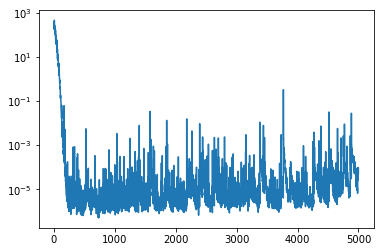

In [5]:
plt.semilogy(loss_history)
loss_history[-1]

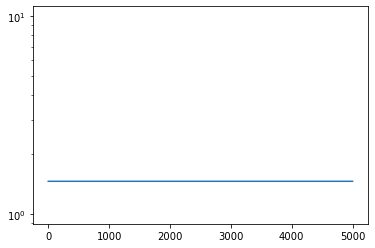

In [6]:
plt.semilogy(scale_history)

In [7]:
rs = model.unit_cell.sample(4*nsamples_space)
rs = (torch.tensor(rs,dtype=torch.float32), 0)

J = model.jacobian(rs)
metric_tensor = model.metric_tensor(J)
print(torch.mean(metric_tensor, dim = 0))

tensor([[ 1.4622e+02, -9.7640e-06],
        [-9.7640e-06,  1.4622e+02]], grad_fn=<MeanBackward1>)


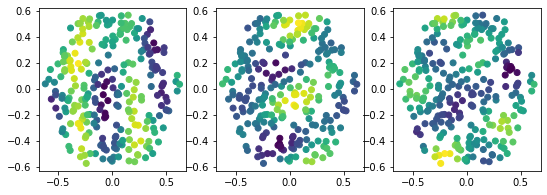

In [8]:
fig,axs = plt.subplots(ncols=3,figsize=(9,3))
axs[0].scatter(*rs[0].T,c=metric_tensor[...,0,0].detach())
axs[1].scatter(*rs[0].T,c=metric_tensor[...,1,1].detach())
axs[2].scatter(*rs[0].T,c=metric_tensor[...,1,0].detach())

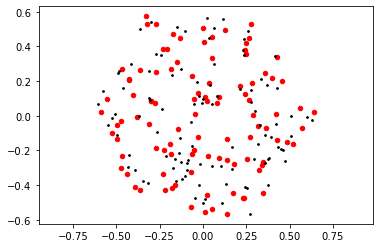

In [9]:
N = len(phases_history)
fig, ax = plt.subplots()
#[ax.scatter(*phases_history[i].T, c='red', s = 2) for i in range(1, N, 100)]
#ax.scatter(*phases_history[-1].T, c='red')
ax.scatter(*model.unit_cell.wrap(phases_history[-1]).T, c='r', s = 20)
ax.scatter(*model.unit_cell.wrap(phases_history[0]).T, c='k',s = 3)

ax.axis('equal')
#model.unit_cell.plot(fig,ax)
#model.unit_cell.plot(fig,ax,center=np.mean(phases_history[-1],axis=0))
plt.show()

In [10]:
torch.save(model,f'./saved-models/{type(model).__name__}-{model.ncells}-dirac')

In [11]:
#import matplotlib.font_manager
#matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
from methods import phase_kde
import scipy


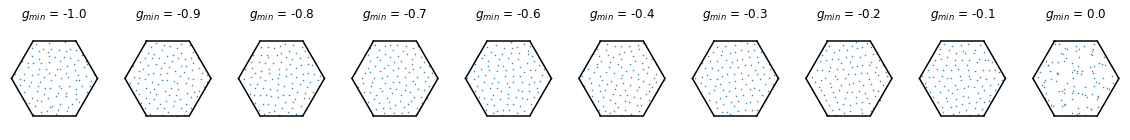

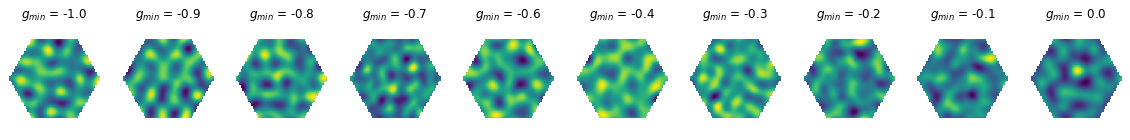

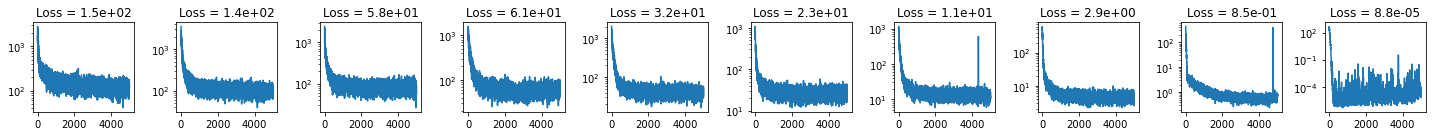

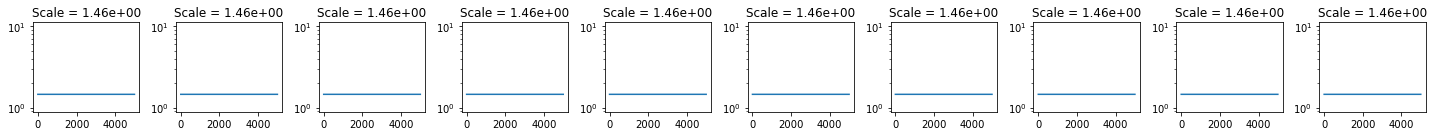

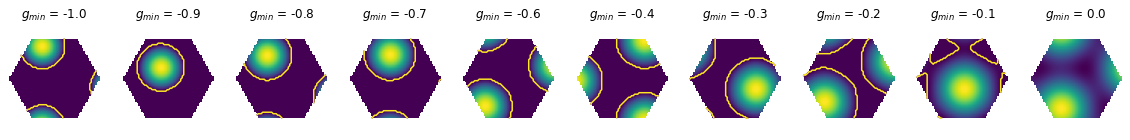

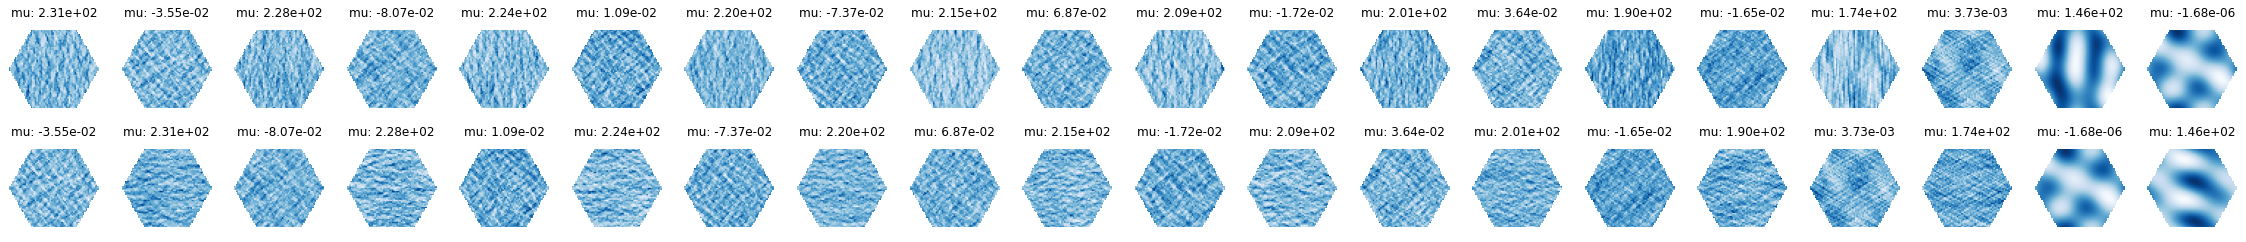

In [12]:
n = 64
eps = 1e-6
lim = 2/3
bins = np.linspace(-lim, lim, n)
#lim = np.amax(np.abs(mesh))

xx, yy = np.meshgrid(bins, bins)
mesh = np.stack((xx.ravel(), yy.ravel()), axis = -1)
mask = ~model.unit_cell.is_in_hexagon(mesh)

try:
    fig, ax = plt.subplots(1, len(a_vals), figsize = (len(a_vals)*2, 2))
    for i, phases in enumerate(final_phases):
        ax[i].plot(*model.unit_cell.wrap(phases).T, ".",markersize = 1)
        #ax[i].plot(*phases.T, ".")

        model.unit_cell.plot(fig, ax[i], color = "k")
        ax[i].set_title(f"{'$g_{min}$'} = {a_vals[i]:.1f}")
        ax[i].axis("off")
        ax[i].axis("equal")
    plt.show()

    fig, ax = plt.subplots(1, len(a_vals), figsize = (len(a_vals)*2, 2))
    for i, phases in enumerate(final_phases):
        kernel, tiled_phases = phase_kde(model.unit_cell, model.unit_cell.wrap(phases), bw_method = 0.1)
        kde = kernel(mesh.T)
        kde[mask] = np.nan
        ax[i].imshow(kde.reshape(n,n), origin = "lower", extent = [-lim, lim, -lim, lim])
        ax[i].set_title(f"{'$g_{min}$'} = {a_vals[i]:.1f}")
        ax[i].axis("off")
        ax[i].axis("equal")
    plt.show()
except RecursionError:
    print("IT BROKE")

fig, ax = plt.subplots(1, len(a_vals), figsize = (len(a_vals)*2, 2))
for i, loss in enumerate(losses):
    ax[i].semilogy(loss)
    ax[i].set_title(f"Loss = {loss[-1]:.1e}")
    #ax[i].axis("off")
    #ax[i].axis("equal")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, len(a_vals), figsize = (len(a_vals)*2, 2))
for i, scale in enumerate(scales):
    ax[i].semilogy(scale)
    ax[i].set_title(f"Scale = {scale[-1]:.2e}")
    #ax[i].axis("off")
    #ax[i].axis("equal")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, len(a_vals), figsize = (len(a_vals)*2, 2))
for i, model in enumerate(models):
    G = model((torch.tensor(mesh, dtype = torch.float32),0)).detach().numpy()
    levels = [0 + eps, eps + 1*eps]

    G[mask] = np.nan
    G = np.reshape(G, (n, n, -1))
    ax[i].contour(xx, yy, G[...,0], levels = levels)
    ax[i].imshow(G[...,0], origin = "lower", extent = [-lim, lim, -lim, lim])
    ax[i].set_title(f"{'$g_{min}$'} = {a_vals[i]:.1f}")
    ax[i].axis("off")
    ax[i].axis("equal")
plt.show()

fig, ax = plt.subplots(2, 2*len(a_vals), figsize = (len(a_vals)*4, 4))
for i, model in enumerate(models):
    J = model.jacobian((torch.tensor(mesh, dtype = torch.float32),0))
    metric = model.metric_tensor(J).detach().numpy()
    metric[mask] = np.nan
    metric = np.reshape(metric, (n, n, 2, 2))
    
    currcol = i*2 # 0, 0, 2, 2, 

    for j in range(4):
        row = j // 2
        col = j % 2
        ax[row, currcol + col].imshow(metric[:,:,row,col], cmap = "Blues")
        num = f"{row}{col}"
        title = f"$g_{{{num}}}$\n"
        #ax[row, currcol + col].set_title(f"{title}Std: {np.nanstd(metric[:,:,row,col]):.2e}")
        ax[row, currcol + col].set_title(f"mu: {np.nanmean(metric[:,:,row,col]):.2e}")
        ax[row, currcol + col].axis("off")
    
    #ax[i].imshow(G[...,0], origin = "lower", extent = [-lim, lim, -lim, lim])
    #ax[i].set_title(f"{'$g_{min}$'} = {a_vals[i]:.1f}")
    #ax[i].axis("off")
    #ax[i].axis("equal")
plt.show()